# TFDS로 train pipeline 구축하기

다음 colab을 따라한 것임
* https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/data.ipynb


* processing multiple epochs by repeat
* ransom shuffle by shuffle
* preprocessing image data by map
* apply python logic
* parsing tf.Example message
* time-series windowing
* resampling
* CheckPoint

In [1]:
import tensorflow as tf

import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

## 여러 번 epoch 반복하기    (Repeat and then Batch)

In [2]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

def plot_batch_sizes(ds):
    batch_sizes = [batch.shape[0] for batch in ds]
    plt.bar(range(len(batch_sizes)), batch_sizes)
    plt.xlabel('Batch number')
    plt.ylabel('Batch size')

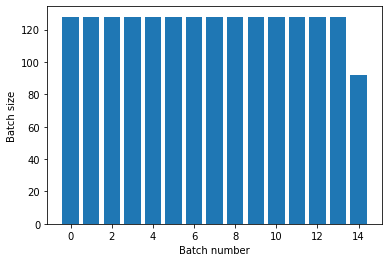

In [8]:
titanic_batches = titanic_lines.repeat(3).batch(128)   # epoch =3 반복
plot_batch_sizes(titanic_batches)

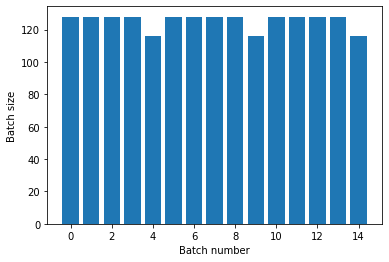

In [9]:
# Batch를 먼저해버리면 제일 마지막의 불충분 미니배치가 epoch마다 반복된다.
titanic_batches = titanic_lines.batch(128).repeat(3)   
plot_batch_sizes(titanic_batches)

## Repeat and then Shuffle 하자

* shuffle and then repeat 하면, epoch boundary에서 섞이지 않는다. 
* repeat and then shuffle 해야 epoch boundary가 섞인다.

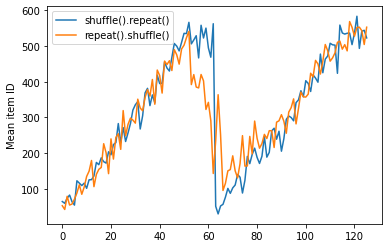

In [15]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
shuffle_repeat_ds = dataset.shuffle(buffer_size=100).batch(10).repeat(2)
repeat_shuffle = [n.numpy().mean() for n, line_batch in repeat_shuffle_ds]

shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffle_repeat_ds]
repeat_shuffle_ds = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

## Image data으로 dataset 만들기

* tf.py_function으로 wrapping해서 tfds.map에 전달해 주어야 한다.

In [27]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)

list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

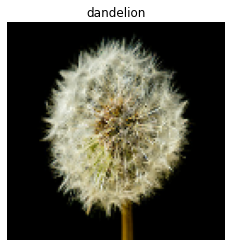

In [28]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
    parts = tf.strings.split(filename, os.sep)
    label = parts[-2]

    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return image, label

def show(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(label.numpy().decode('utf-8'))
    plt.axis('off')

images_ds = list_ds.map(parse_image)

image, label = next(iter(images_ds))
show(image, label)

### Pure Python 함수를 사용해서 transform하기 

* tf.py_function으로 wrapping해서 tfds.map에 전달해 주어야 한다

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


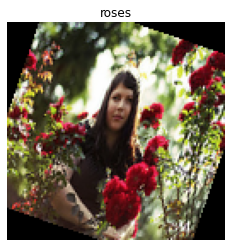

In [29]:
import scipy.ndimage as ndimage

def random_rotate_image(image):
    image = ndimage.rotate(image, np.random.uniform(-30,30), reshape=False)
    return image

# tf.py_function으로 wrapping해서 tfds.map에 전달해 주어야 한다.
def tf_random_rotate_image(image, label):
    im_shape = image.shape
    [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label


rot_ds = images_ds.map(tf_random_rotate_image)

image, label = next(iter(rot_ds))

show(image, label)

## TFRecord에서 TF.Example protocol buffer message parsing 처리하기 

In [46]:
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])

def tf_parse(eg):
    example = tf.io.parse_example(
    eg[tf.newaxis], {
      'image/encoded': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
      'image/text': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
    })
    return example['image/encoded'][0], example['image/text'][0]

decoded = dataset.map(tf_parse)
decoded

<MapDataset shapes: ((), ()), types: (tf.string, tf.string)>

b'Rue Perreyon'


(-0.5, 599.5, 149.5, -0.5)

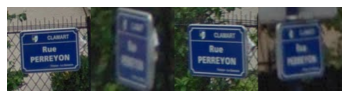

In [47]:
image_batch, text_batch = next(iter(decoded.batch(10)))

print(text_batch[0].numpy())

img = tf.image.decode_png(image_batch[0].numpy())
plt.imshow(img)
plt.axis('off')

# Imbalance data 에서 균등한 MiniBatch 생성하기

### class 편중 확인하기

In [55]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/download.tensorflow.org/data/creditcard.zip',
    fname='creditcard.zip',
    extract=True)

csv_path = zip_path.replace('.zip', '.csv')

creditcard_ds = tf.data.experimental.make_csv_dataset(
    csv_path, batch_size=1024, label_name="Class",
    # Set the column types: 30 floats and an int.
    column_defaults=[float()]*30+[int()])

def count(counts, batch):
    features, labels = batch
    class_1 = labels == 1
    class_1 = tf.cast(class_1, tf.int32)

    class_0 = labels == 0
    class_0 = tf.cast(class_0, tf.int32)

    counts['class_0'] += tf.reduce_sum(class_0)
    counts['class_1'] += tf.reduce_sum(class_1)

    return counts

counts = creditcard_ds.take(10).reduce(
    initial_state={'class_0': 0, 'class_1': 0},
    reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

fractions = counts/counts.sum()
print(fractions)

[0.9959 0.0041]


In [53]:
for features, labels in creditcard_ds.take(10):
    print(labels.numpy())
    print(labels.numpy().shape)

[0 0 0 ... 0 0 0]
(1024,)
[0 0 0 ... 0 0 0]
(1024,)
[0 0 0 ... 0 0 0]
(1024,)
[0 0 0 ... 0 0 0]
(1024,)
[0 0 0 ... 0 0 0]
(1024,)
[0 0 0 ... 0 0 0]
(1024,)
[0 0 0 ... 0 0 0]
(1024,)
[0 0 0 ... 0 0 0]
(1024,)
[0 0 0 ... 0 0 0]
(1024,)
[0 0 0 ... 0 0 0]
(1024,)


### Sample_from_dataset을 이용한 균등 샘플링

In [51]:
pos_ds = creditcard_ds.unbatch().filter(lambda features,label: label == 1).repeat()
neg_ds = creditcard_ds.unbatch().filter(lambda features,label: label == 0).repeat()

balance_ds = tf.data.experimental.sample_from_datasets(
    [neg_ds, pos_ds], [0.5, 0.5]).batch(10)

for features, labels in balance_ds.take(10):
    print(labels.numpy())

[0 1 0 0 1 0 0 1 1 0]
[0 1 1 0 1 0 1 0 1 1]
[1 0 1 0 1 1 1 0 1 1]
[1 1 0 1 1 0 1 0 0 1]
[1 1 0 0 1 1 1 0 0 0]
[1 1 0 0 0 0 0 1 1 0]
[0 0 0 0 1 1 1 0 1 0]
[1 1 1 0 1 0 0 0 1 0]
[1 1 0 0 1 0 1 0 0 1]
[0 1 1 1 0 0 0 0 1 1]


### Rejection resampling

* sample_from_dataset의 단점은 클래스마다 별도의 ds를 생성해야 한다는 점,
* 즉 여러번 로딩이 불필요하게 반복된다.
* 반면 rejection resample은 단 한번만 로딩을 하면서도 밸런스를 맞추어준다. 
* class_func를 넘겨줘서 밸런스의 기준값을 정해주면 된다. 

In [59]:
def class_func(features, label):
    return label

resampler = tf.data.experimental.rejection_resample(
    class_func, target_dist=[0.5, 0.5], initial_dist=fractions)

resample_ds = creditcard_ds.unbatch().apply(resampler).batch(10)

In [61]:
# resampler가 (class, example)을 리턴하는데, 여기서는 example 내에 이미 class label이 있으므로 이를 drop하자
balanced_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

for features, labels in balanced_ds.take(10):
    print(labels.numpy())

[0 0 1 0 0 1 0 0 1 1]
[0 1 1 0 0 1 0 0 0 1]
[1 1 0 1 1 1 1 1 0 1]
[1 0 0 1 0 1 0 0 1 1]
[1 0 0 0 1 0 1 1 0 0]
[0 0 1 0 1 1 1 1 1 0]
[1 0 1 0 0 1 1 0 1 1]
[1 1 0 1 0 0 1 1 0 1]
[0 0 0 1 0 1 0 1 0 1]
[1 0 0 1 1 0 0 1 0 0]


## CheckPoint를 이용해서 iteration 위치 복구하기

In [63]:
range_ds = tf.data.Dataset.range(20)

iterator = iter(range_ds)
ckpt = tf.train.Checkpoint(step=tf.Variable(0), iterator=iterator)
manager = tf.train.CheckpointManager(ckpt, '/tmp/my_ckpt', max_to_keep=3)

print([next(iterator).numpy() for _ in range(5)])

save_path = manager.save() # 위치 5에서 기억

print([next(iterator).numpy() for _ in range(5)])

ckpt.restore(manager.latest_checkpoint)

print([next(iterator).numpy() for _ in range(5)])

[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9]
[5, 6, 7, 8, 9]
